# Granger Causality

The goal is to understand wether an additional time series x improves the prediction of time series y. In order to do that, the autoregression is compared to the regression using both time series. Using XOR secret computing, time series x can remain completely private which allows the private discovery of model improving datasets.

In this example we will use rainfall and temperature data between the years 1981 and 1990, collected in Melbourne (AUS). Our aim is to see wheter we can get better temperature predictions if we include rainfall from the past couple of days as an additional temperature predictor. 


In [38]:
####### import libraries #########
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

In [39]:
####### import datasets ##########
print('the first 5 lines of each dataset \n')

rainfall = pd.read_csv('daily-rainfall-in-melbourne-aust.csv', parse_dates=['Date'], header=0, squeeze=True);
rainfall.set_index('Date',inplace=True)
print(rainfall.head())

temperature = pd.read_csv('daily-minimum-temperatures-in-melbourne-aust.csv', parse_dates=['Date'], header=0, squeeze=True);
temperature.set_index('Date',inplace=True)
print(temperature.head())

the first 5 lines of each dataset 

            Daily rainfall in Melbourne, Australia, 1981-1990
Date                                                         
1981-01-01                                                  0
1981-01-02                                                  0
1981-01-03                                                 78
1981-01-04                                                 22
1981-01-05                                                  2
            Daily minimum temperatures in Melbourne, Australia, 1981-1990
Date                                                                     
1981-01-01                                               20.7            
1981-01-02                                               17.9            
1981-01-03                                               18.8            
1981-01-04                                               14.6            
1981-01-05                                               15.8            


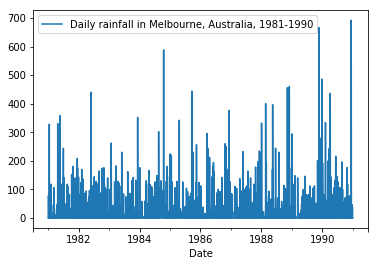

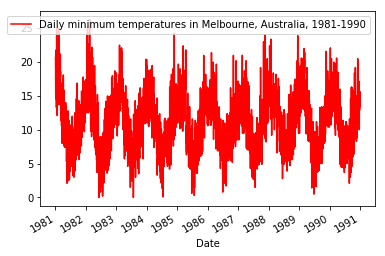

In [40]:
####### plot datasets ##########
rainfall.plot()
temperature.plot(color='r')

In [41]:
####### preprocessing ##########
# use the preprocessing script to prepare the time series for XOR computations
# we use: 
# * lag lower bound <= 1 day
# * lag upper bound <= 5 days
# * window size for autocorrelation <= 10 days
################################

%run -i grangerPreprocessing.py --input 'daily-minimum-temperatures-in-melbourne-aust.csv' --lag-min 0 --lag-max 10 --output 'y.csv'
%run -i grangerPreprocessing.py --input 'daily-rainfall-in-melbourne-aust.csv' --lag-min 1 --lag-max 5  --output 'x.csv'

# adjust number of lines:
x_lines = !wc -l x.csv
y_lines = !wc -l y.csv
x_lines = int(''.join(map(str, [int(s) for s in list(x_lines[0]) if s.isdigit()])))
y_lines = int(''.join(map(str, [int(s) for s in list(y_lines[0]) if s.isdigit()])))
min_lines = min(x_lines, y_lines)
lines = "\'1,"+str(min_lines)+" p\'"
!sed -n -i $lines x.csv
!sed -n -i $lines y.csv


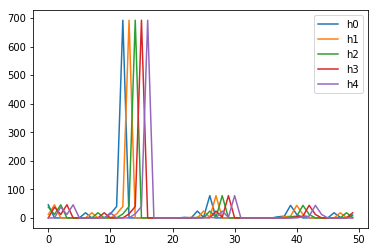

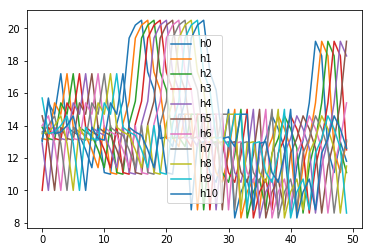

In [42]:
####### preprocessing ##########
# the preprocessing produced the following time shifts, displayed with the first 50 samples
x = pd.read_csv('x.csv', header=0);
x.head(50).plot()
y = pd.read_csv('y.csv', header=0);
y.head(50).plot()



# Plaintext Computations

We compute the regressions in plaintext and later compare them to the XOR computations. The equation we are using is of the form: 

$$ \hat{y} = \alpha_0 + \alpha_1*T_{t-1} + \cdots + \alpha_n*T_{t-n} + \beta_1*R_{t-1} + \cdots + \beta_p*R_{t-p} $$

* Where $\hat{y}$ is our tempereature predictor
* $t$ count of days
* $T$ are the temperature values from the past days (measured by t)
* $R$ are the rainfall values from the past days (measured by t)
* $n$ and $p$ are the time shift values we use for both time series (how far we look back)
* The $\alpha$ and $\beta$ coefficients compose the prediction vector we want to compute


In [43]:
# compute the autoregression (temperature data only)
dataTrain = np.loadtxt('y.csv', delimiter=',', skiprows=1)
XTrain = dataTrain[:,[0,1,2,3,4,5,6,7,8,9]]
print(XTrain.shape)
YTrain = dataTrain[:,[10]]
model = LinearRegression()
model.fit(XTrain, YTrain)
autoregression_results = [np.append(model.intercept_,model.coef_)]
print("Numpy (sklearn) plaintext autoregression computation (alpha vector):\n")
print(autoregression_results)

(3640, 10)
Numpy (sklearn) plaintext autoregression computation (alpha vector):

[array([ 0.933556  ,  0.03634852,  0.05002657,  0.03221983,  0.05982734,
        0.04163205,  0.05479624,  0.05120328,  0.06325258, -0.08322126,
        0.60993244])]


In [44]:
###########################
# Run the regression on XOR and paste the results here
###########################
xor_autoregression_results = [0.933556, 0.036349, 0.050027, 0.032220, 0.059827, 0.041632, 0.054796, 0.051203, 0.063253, -0.083221, 0.609932]
np.subtract(autoregression_results, xor_autoregression_results)

array([[-2.02680428e-09, -4.83497366e-07, -4.32407907e-07,
        -1.66013604e-07,  3.38788570e-07,  4.76942841e-08,
         2.37785548e-07,  2.76418563e-07, -4.15830871e-07,
        -2.57224719e-07,  4.37855859e-07]])

## <span style="color:red">Note: the error between the plaintext and the XOR computation is of the order of magnitude $10^{-7}$</span>  

In [45]:
# compute the regression using both inputs (temperature and rainfall) 
dataTrainTemp = np.loadtxt('y.csv', delimiter=',', skiprows=1)
dataTrainRain = np.loadtxt('x.csv', delimiter=',', skiprows=1)
XTrain = np.concatenate((dataTrainTemp[:,[0,1,2,3,4,5,6,7,8,9]], dataTrainRain[0:3640,:]), axis=1)
print(XTrain.shape)
YTrain = dataTrainTemp[:,[10]]
model = LinearRegression()
model.fit(XTrain, YTrain)
results = [np.append(model.intercept_,model.coef_)]
print("Numpy (sklearn) plaintext computation (alpha + beta vector ):\n")
print(results)

(3640, 15)
Numpy (sklearn) plaintext computation (alpha + beta vector ):

[array([ 9.79860884e-01,  3.72059333e-02,  4.95416631e-02,  3.23350968e-02,
        5.94686781e-02,  4.12431613e-02,  5.48837414e-02,  5.12205249e-02,
        6.31562029e-02, -8.31445141e-02,  6.09528726e-01, -1.08818099e-03,
       -5.41087316e-04, -1.94218326e-04, -4.85861818e-04, -4.40567060e-05])]


In [64]:
###########################
# Run the regression on XOR and paste the results here
###########################
xor_results = [0.979861, 0.037206, 0.049542, 0.032335, 0.059469, 0.041243, 0.054884, 0.051221, 0.063156, -0.083145, 0.609529, -0.001088, -0.000541, -0.000194, -0.000486, -0.000044]
np.subtract(results, xor_results)

array([[-1.15926593e-07, -6.67110455e-08, -3.36894524e-07,
         9.67975113e-08, -3.21864646e-07,  1.61274999e-07,
        -2.58622817e-07, -4.75104014e-07,  2.02941348e-07,
         4.85875973e-07, -2.74351101e-07, -1.80987905e-07,
        -8.73157026e-08, -2.18325644e-07,  1.38181738e-07,
        -5.67060437e-08]])

## <span style="color:red">Note: same order of magnitude for the error</span> 

# Granger Causality

Finally we want to find out what information from the rainfall has significance on our temperature prediction. XOR can calculate the error between our predicted model $\hat y$ and $y$ the real daily temperature values.
$$\mid\hat y - y\mid^2$$  

Once we have the error of our model compared to the real values, we can identify the significant coefficients in our model. We use t and f stats. 

Since the standard deviation of the features is public (publicly known at the time of the computation) and since we are able to compute the RSS and reveal it, one can compute the t-score in public. Once this is done, we determine the p-value and hence, the statistical significance of the coefficient.

The t-test measures the significance of each coefficient in our prediction model (coefficients $\alpha$ and $\beta$ in the above formula). We want to know which of the time shifts of temperature or rain are valuable to our prediction $\hat y$. Our hypotheses are the following: $H_0 : \beta_i = 0$ and $H_1 : \beta_i \neq 0$ (note: $\beta_i$ stands for the $\beta$ AND the $\alpha$ in the above fomula of $\hat y$), where the 0 hypothesis would mean that we disregard this time shift for our predictor. 

We first compute $T_0$:
$$T_0 = \frac{\hat \beta_i - \beta_{H_0}}{se(\hat \beta_i)}$$
Where $\beta_{H_0} = 0$ (the 0 hypothesis) and $se(\hat \beta_i)$ is: 

$$se(\hat \beta_i) = \sqrt{\frac{\sum\limits_{k=1}^n e_k^2 }{\left( \sum\limits_{k=1}^n (x_{ki}-\bar{x_i})^2\right) (n-2)}} = \sqrt{\frac{RSS}{\sigma_i^2(n-2)}}$$

with $RSS$ the residual sum of squares and $\sigma$ the variance. The test statistic, $T_0$ , follows a Students t-distribution with $(n-2)$ degrees of freedom, where $n$ is the total number of observations. The null hypothesis, $H_0$, is accepted if the calculated value of the test statistic is such that:

$$-t_{\alpha/2,n-2}\lt T_0 \lt t_{\alpha/2,n-2}$$


where $-t_{\alpha/2,n-2}$ and $t_{\alpha/2,n-2}$ are the critical values for the two-sided hypothesis. Here $t_{\alpha/2,n-2}$ is the percentile of the $t$ distribution corresponding to a cumulative probability of $(1-\alpha/2)$ and $\alpha$ is the significance level.


In [65]:
# Plaintex calculation
rss = ((model.predict(XTrain) - YTrain) ** 2).sum()
###########################
# Run the regression on XOR and paste the results here
###########################
xor_rss = 21386.569031

rss_diff = np.abs(rss - xor_rss)
print("Difference between XOR and plaintext RSS computations: ", rss_diff)

Difference between XOR and plaintext RSS computations:  0.0011157682602060959


## <span style="color:red">Again we find very small differences between the plaintext computations and the XOR computations</span>

## The rest of the computations will be done in plaintext, as explained above all statistically relevant data is now known

In [66]:
var_x = XTrain.var(axis=0)
n = XTrain.shape[0]

se = np.power((np.divide(rss,np.multiply(var_x,(n-2)))), 0.5)

t_vals = np.divide(results[0][1:], se)
p_vals = (scipy.stats.t.cdf(t_vals, n-2))

significance_level = 0.05

keep_betas = list(map((lambda p: 'False' if p > significance_level else 'True'), p_vals))

# print
np.set_printoptions(suppress=True)
print("t-test values: ")
print(t_vals)
print("p values: ")
print(p_vals)
print("keep coefficients: ")
print(keep_betas)
np.set_printoptions(suppress=False)


t-test values: 
[ 0.06252385  0.08319406  0.05428248  0.09978582  0.06919916  0.09207838
  0.08592301  0.10593156 -0.13941912  1.02128875 -0.0213142  -0.01059811
 -0.00380418 -0.00951665 -0.00086252]
p values: 
[0.52492545 0.53314909 0.52164346 0.53974007 0.52758255 0.53667958
 0.53423383 0.54217875 0.44456334 0.84640722 0.49149809 0.49577234
 0.49848246 0.49620372 0.49965593]
keep coefficients: 
['False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False']


## We conclude that with the past temparature and rainfall data we cannot granger cause a reliable temperature prediciton